In [2]:
import os
import glob
import itertools
import json
import cv2
import sys

import matplotlib as mpl
import scipy.stats as spstats
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as pl
import pingouin as pg
# 
import analyze2p.gratings.utils as gutils
import analyze2p.plotting as pplot
import analyze2p.aggregate_datasets as aggr
import analyze2p.utils as hutils
import analyze2p.receptive_fields.utils as rfutils
import analyze2p.extraction.rois as roiutils
import analyze2p.correlations as cr
import importlib

import analyze2p.objects.selectivity as sel
import analyze2p.objects.sim_utils as su

In [4]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(axis_labelsize=7, lw_axes=0.25)
bw_colors = dict((v, [0.7]*3) for v in visual_areas)
#### Set trace ID and FOV/state type
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir='/n/coxfs01/2p-data'

new_root = '/n/holylfs05/LABS/pfister_lab/Lab'
aggregate_dir = aggregate_dir.replace('/n', new_root)
rootdir = rootdir.replace('/n', new_root)

traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'

In [5]:
experiment = 'blobs'
responsive_test='ROC'
# ---------------------------------------------------------------
response_type='dff'
if experiment=='rfs' and responsive_test=='nstds':
    responsive_thr=7.0
else:
    responsive_thr=0.05 if responsive_test=='ROC' else 10.0
print(responsive_test, responsive_thr)

ROC 0.05


# Load data

In [6]:
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
meta = sdata[sdata.experiment.isin(['gratings'])].copy()
all_dkeys = [(va, dk) for (va, dk), g in meta.groupby(['visual_area', 'datakey'])]

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets


In [7]:
# Load trial metrics
trial_epoch='stimulus'
NDATA0 = aggr.load_responsive_neuraldata(experiment, traceid=traceid,
                      response_type=response_type, trial_epoch=trial_epoch,
                      responsive_test=responsive_test, 
                      responsive_thr=responsive_thr)
if experiment not in ['rfs', 'rfs10']: # assigned in load_responsive_neuraldata()
    NDATA0['experiment'] = experiment 
print("Stimulus: %s (cell counts)" % experiment)
print(NDATA0[['visual_area', 'datakey', 'cell']]\
        .drop_duplicates()['visual_area'].value_counts().to_markdown())
# Get the cells
CELLS = aggr.get_all_responsive_cells(cells0, NDATA0) 
print(CELLS[['visual_area', 'animalid', 'session', 'fovnum']]\
            .drop_duplicates()['visual_area'].value_counts().to_markdown())

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets
...loading: aggr_blobs_trialmeans_traces001_ROC-thr-0.05_dff_stimulus.pkl
Checking mislabeled
Stimulus: blobs (cell counts)
|    |   visual_area |
|:---|--------------:|
| V1 |          1259 |
| Lm |          1048 |
| Li |           583 |
|    |   visual_area |
|:---|--------------:|
| Li |            18 |
| Lm |            16 |
| V1 |            16 |


In [8]:
SDF, incorrect_stim = aggr.check_sdfs(NDATA0['datakey'].unique(), 
                            experiment=experiment,
                            images_only=False, rename=experiment=='blobs',
                            return_incorrect=True, return_all=False)
incorrect_stim.keys()

dict_keys(['20190314_JC070_fov1', '20190315_JC070_fov1', '20190316_JC070_fov1', '20190319_JC067_fov1', '20190320_JC067_fov1', '20190321_JC070_fov1', '20190322_JC073_fov1', '20190327_JC073_fov1'])

In [9]:
min_ncells=10
# -------------------------------------------
counts0 = aggr.count_n_cells(CELLS,
                            name='n_cells', reset_index=True)
# Get unique dkeys based on # cells fit
counts = counts0[(counts0.datakey.isin(SDF['datakey'].unique()))
               & (counts0.n_cells>=min_ncells)]
print(counts.groupby('visual_area').sum().to_markdown())
# Drop duplicates
u_dkeys = aggr.drop_repeats(counts, colname='n_cells') 

NDATA = pd.concat([g for (va, dk), g \
                   in NDATA0.groupby(['visual_area', 'datakey'])\
                   if (va, dk) in u_dkeys and dk in SDF['datakey'].unique()], 
                  ignore_index=True)
if 'experiment' not in NDATA.columns:
    NDATA['experiment'] = experiment
# Final counts
final_ncells = aggr.count_n_cells(NDATA)
final_totals = aggr.get_final_cell_and_site_counts(final_ncells)
print("FINAL totals: %s (%s)" % (experiment, responsive_test))
print(final_totals.to_markdown())

| visual_area   |   n_cells |
|:--------------|----------:|
| Li            |       472 |
| Lm            |      1016 |
| V1            |      1257 |
[V1] Animalid does not exist: JC078 
FINAL totals: blobs (ROC)
| visual_area   |   n_cells |   datakey |
|:--------------|----------:|----------:|
| Li            |       331 |         6 |
| Lm            |       628 |         8 |
| V1            |      1031 |         9 |


## Get RFs

In [29]:
response_type='dff'
do_spherical_correction=False
combine_rfs='average'
# ------------------------------------
rf_fit_desc = rfutils.get_fit_desc(response_type=response_type,
                                  do_spherical_correction=do_spherical_correction)
rfdf = rfutils.aggregate_fits(cells0, sdata, combine=combine_rfs, 
                              response_type=response_type,
                              do_spherical_correction=do_spherical_correction,
                              reliable_only=True,
                              pass_criterion='position',
                              rootdir=rootdir)
rfdf = aggr.add_roi_positions(rfdf, rootdir=rootdir)

rf_correction_str = 'sphrcorr' if do_spherical_correction else 'uncorr'
rf_str = 'rfs-%s-%s' % (response_type, rf_correction_str)
print(rf_str)
# Get polygons
try:
    rfpolys, _ = su.load_rfpolys(rf_fit_desc, combine_method=combine_rfs,
                                 aggregate_dir=aggregate_dir)
except FileNotFoundError as e:
    print("Creating new RF polys...")
    rfpolys, check_rfs = su.update_rfpolys(rfdf, rf_fit_desc, 
                                    combine_method=combine_rfs,
                                    create_new=True,
                                    aggregate_dir=aggregate_dir)

N dpaths: 58, N unfit: 0
N datasets included: 63, N sessions excluded: 4
N dpaths: 58, N unfit: 0
N datasets included: 63, N sessions excluded: 4
rfs-dff-uncorr


In [9]:
importlib.reload(su)

<module 'analyze2p.objects.sim_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/objects/sim_utils.py'>

In [30]:
rfpolys.head()

,poly,cell,datakey
0,"MULTIPOLYGON (((1263 465, 1262 466, 1248 466, ...",2.0,20190511_JC083_fov1
1,"MULTIPOLYGON (((1266 432, 1265 433, 1254 433, ...",4.0,20190511_JC083_fov1
2,"MULTIPOLYGON (((1341 601, 1340 602, 1332 602, ...",12.0,20190511_JC083_fov1
3,"MULTIPOLYGON (((1221 279, 1220 280, 1216 280, ...",20.0,20190511_JC083_fov1
4,"MULTIPOLYGON (((1291 398, 1290 399, 1284 399, ...",24.0,20190511_JC083_fov1


# Output dirs

In [31]:
responsive_str = '%s_%s-%.2f' % (response_type, responsive_test, responsive_thr)
data_id = '|'.join([traceid, responsive_str, rf_str])
print(data_id)

#### Set current output dir
base_dir = os.path.join(aggregate_dir, 'correlations', 
                       'blobs_%s_%s' % (response_type, responsive_test),
                       'morph_tuning')
print(base_dir)
print(base_dir)
FIGDIR = os.path.join(aggregate_dir, 'FIGURES', 'correlate_tuning_curves_MIGR')
if not os.path.exists(FIGDIR):
    os.makedirs(FIGDIR)
print(FIGDIR)

traces001|dff_ROC-0.05|rfs-dff-uncorr
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/FIGURES/correlate_tuning_curves_MIGR


# Aggregate

In [15]:
import _pickle as pkl
import copy

In [32]:
offset_type='minsub' 
lcorrection='none'
with_lum = True
# ----------------------------------------
# Results outfile
blob_str = '%s_%s-%s' % (responsive_test, offset_type, lcorrection)
print(blob_str)
print(rf_str)
dists_results_file = os.path.join(base_dir, 'results_%s_%s.pkl' % (blob_str, rf_str))
print(dists_results_file)

# Figure save dir
dst_dir = os.path.join(base_dir, '%s_%s' % (blob_str, rf_str))
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
print(dst_dir)

ROC_minsub-none
rfs-dff-uncorr
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning/results_ROC_minsub-none_rfs-dff-uncorr.pkl
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning/ROC_minsub-none_rfs-dff-uncorr


In [37]:
create_new=False
if not create_new:
    try:
        with open(dists_results_file, 'rb') as f:
            res = pkl.load(f)
        DISTS = res['DISTS']
        avg_responses = res['responses']
        rfdf = res['rfdf']
        del res
    except Exception as e:
        create_new=True
print("new? %s" % str(create_new))

new? False


In [38]:
print(create_new)

False


In [39]:
avg_responses.head()

,visual_area,datakey,cell,config,response,size,morphlevel,experiment
0,Li,20190422_JC076_fov1,76,config001,0.755966,10.0,-1,blobs
1,Li,20190422_JC076_fov1,76,config002,0.210776,20.0,-1,blobs
2,Li,20190422_JC076_fov1,76,config003,0.074085,30.0,-1,blobs
3,Li,20190422_JC076_fov1,76,config004,0.080177,40.0,-1,blobs
4,Li,20190422_JC076_fov1,76,config005,0.076753,50.0,-1,blobs


In [40]:
# Calculate distances
with_lum=True
if create_new:
    rdf_list=[]
    for (va, dk), x0 in NDATA.groupby(['visual_area', 'datakey']):

        sdf = aggr.get_stimuli(dk, experiment, match_names=True)
        if with_lum:
            configs = sdf.index.tolist()
        else:
            configs = sdf[sdf['morphlevel']!=-1].index.tolist()
        sizes = list(sorted(sdf['size'].unique()))
        morphlevels = list(sorted(sdf.loc[configs]['morphlevel'].unique()))
        
        # Exclude lum, if relevant
        tmp_cfgs = sdf.index.tolist() if lcorrection!='none' else configs
        x0 = NDATA0[(NDATA0.visual_area==va) & (NDATA0.datakey==dk) 
                  & (NDATA0.config.isin(tmp_cfgs))].copy()
        rdf0 = x0.groupby(['visual_area', 'datakey', 'cell', 'config'])\
                 .mean().reset_index().drop('trial', axis=1)
        rdf_offset = sel.correct_offset(rdf0, offset=offset_type)
        rdf = sel.correct_luminance(rdf_offset, sdf, lcorrection=lcorrection)
        if lcorrection=='exclude':
            print('    %s, %s: excl. %i of %i' \
                  % (va, dk, len(rdf['cell'].unique()),
                     len(rdf_offset['cell'].unique())))

        rdf['size'] = sdf.loc[rdf['config']]['size'].values
        rdf['morphlevel'] = sdf.loc[rdf['config']]['morphlevel'].values
        rdf_list.append(rdf[rdf.config.isin(configs)])
    avg_responses = pd.concat(rdf_list, axis=0, ignore_index=True)
    avg_responses['experiment'] = 'blobs'

In [41]:
avg_responses.head()

,visual_area,datakey,cell,config,response,size,morphlevel,experiment
0,Li,20190422_JC076_fov1,76,config001,0.755966,10.0,-1,blobs
1,Li,20190422_JC076_fov1,76,config002,0.210776,20.0,-1,blobs
2,Li,20190422_JC076_fov1,76,config003,0.074085,30.0,-1,blobs
3,Li,20190422_JC076_fov1,76,config004,0.080177,40.0,-1,blobs
4,Li,20190422_JC076_fov1,76,config005,0.076753,50.0,-1,blobs


In [42]:
if create_new:
    if experiment=='blobs':
        select_stimuli='images'
    else:
        select_stimuli='all'
    distance_var = 'rf_distance'
    min_ncells=5
    DISTS = cr.aggregate_ccdist(NDATA, experiment=experiment, rfdf=rfdf, rfpolys=rfpolys,
                        SDF=SDF, select_stimuli=select_stimuli,min_ncells=min_ncells,
                        distance_var=distance_var, verbose=True)

In [43]:
if create_new:
    res = {'rfdf': rfdf, 'DISTS': DISTS, 'NDATA': NDATA,
           'responses': avg_responses}
    with open(dists_results_file, 'wb') as f:
        pkl.dump(res, f, protocol=2)

# CORRS:  signal_cc and noise_cc

In [44]:
NDATA1 = NDATA.copy()
NDATA = pd.concat([NDATA1[(NDATA1.visual_area==va) & (NDATA1.datakey==dk)
                        & (NDATA1.cell.isin(g['cell'].unique()))] \
                for (va, dk), g in avg_responses.groupby(['visual_area', 'datakey'])])

In [45]:
NDATA1.shape, NDATA.shape

((2929243, 7), (2929243, 7))

In [46]:
cnts_responsive = aggr.count_n_cells(NDATA)
cnts_responsive

,visual_area,datakey,n_cells
0,Li,20190422_JC076_fov1,29
1,Li,20190602_JC091_fov1,87
2,Li,20190614_JC091_fov1,78
3,Li,20191018_JC113_fov1,47
4,Li,20191111_JC120_fov1,30
5,Lm,20190422_JC076_fov1,22
6,Lm,20190430_JC078_fov1,98
7,Lm,20190504_JC078_fov1,59
8,Lm,20190506_JC080_fov1,143
9,Lm,20190508_JC083_fov1,97


In [47]:
select_stimuli='all'
min_ncells=10
CORRS = cr.aggregate_ccdist(NDATA, experiment=experiment, #rfdf=rfdf,
                        SDF=SDF, select_stimuli=select_stimuli,min_ncells=min_ncells,
                        verbose=True, rootdir=rootdir)

Dist: cortical_distance
Li 20190422_JC076_fov1 blobs
Li 20190602_JC091_fov1 blobs
Li 20190614_JC091_fov1 blobs
Li 20191018_JC113_fov1 blobs
Li 20191111_JC120_fov1 blobs
Lm 20190422_JC076_fov1 blobs
Lm 20190430_JC078_fov1 blobs
Lm 20190504_JC078_fov1 blobs
Lm 20190506_JC080_fov1 blobs
Lm 20190508_JC083_fov1 blobs
Lm 20190525_JC084_fov1 blobs
Lm 20190618_JC097_fov1 blobs
Lm 20190627_JC091_fov1 blobs
V1 20190501_JC076_fov1 blobs
V1 20190507_JC083_fov1 blobs
V1 20190512_JC083_fov1 blobs
V1 20190522_JC084_fov1 blobs
V1 20190613_JC097_fov1 blobs
V1 20190616_JC097_fov1 blobs
V1 20190617_JC097_fov1 blobs
V1 20190622_JC085_fov1 blobs
V1 20191006_JC110_fov1 blobs
0 datasets w wrong configs:
0 datasets w/out RF fits:


In [48]:
'20190617_JC099_fov1' in CORRS['datakey'].values

False

In [26]:
importlib.reload(pplot)

<module 'analyze2p.plotting' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/plotting.py'>

#### Average signal/noise ccs. by FOV

<IPython.core.display.Javascript object>


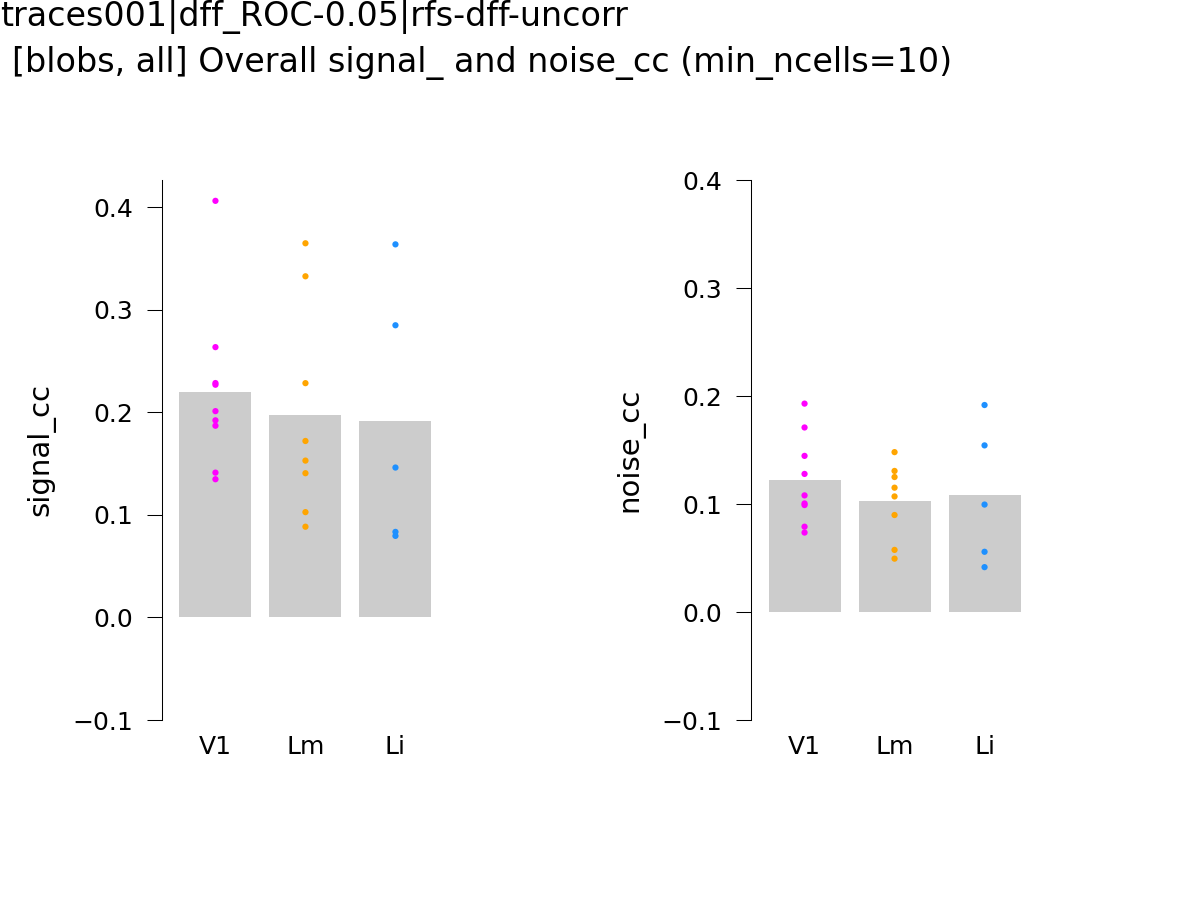

0
1
    A   B  p-unc  p-corr p-adjust     metric
0  V1  Lm   0.42     1.0   fdr_by  signal_cc
1  V1  Li   0.61     1.0   fdr_by  signal_cc
2  Lm  Li   0.62     1.0   fdr_by  signal_cc
0  V1  Lm   0.54     1.0   fdr_by   noise_cc
1  V1  Li   0.61     1.0   fdr_by   noise_cc
2  Lm  Li   1.00     1.0   fdr_by   noise_cc


In [49]:
%matplotlib notebook
ymin, ymax = [-0.1, 0.4]
posthoc='fdr_by'
corrs_fov = CORRS.groupby(['visual_area', 'datakey']).median().reset_index()
fig, axn =pl.subplots(1, 2, figsize=(4,3), dpi=150, sharey=False)
stat_list=[]
for ci, metric in enumerate(['signal_cc', 'noise_cc']):
    ax=axn[ci]
    print(ci)
    ax, stats_ = pplot.stripplot_metric_by_area(corrs_fov, metric=metric, ax=ax,
                markersize=3,area_colors=area_colors,mean_style='bar', 
                posthoc=posthoc, return_stats=True,
                mean_type='mean', y_loc=0.3, jitter=False, aspect=2)

    stats_['metric'] = metric
    stat_list.append(stats_)
    ax.set_yticks(np.linspace(ymin, ymax, 6))
fig.text(0.01, 0.92, '[%s, %s] Overall signal_ and noise_cc (min_ncells=%i)' 
         % (experiment, select_stimuli, min_ncells), fontsize=8)

statsdf_cc = pd.concat(stat_list, axis=0)

pplot.label_figure(fig, data_id)
figname = 'overall_sig_and_noise_cc_byFOV' 
# pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(statsdf_cc.round(2))


In [65]:
7.1/2.5

2.84

<IPython.core.display.Javascript object>


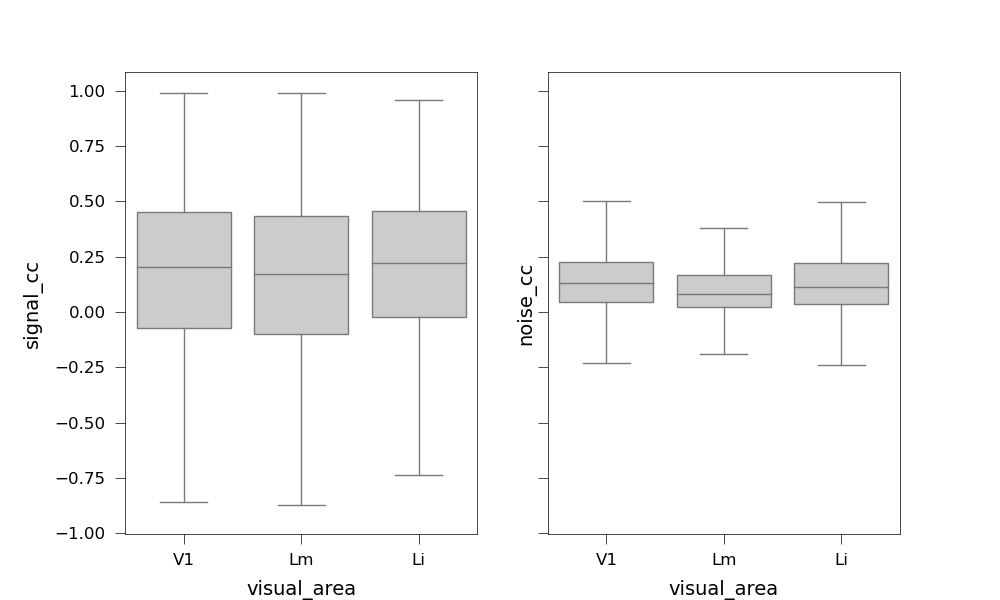

<IPython.core.display.Javascript object>


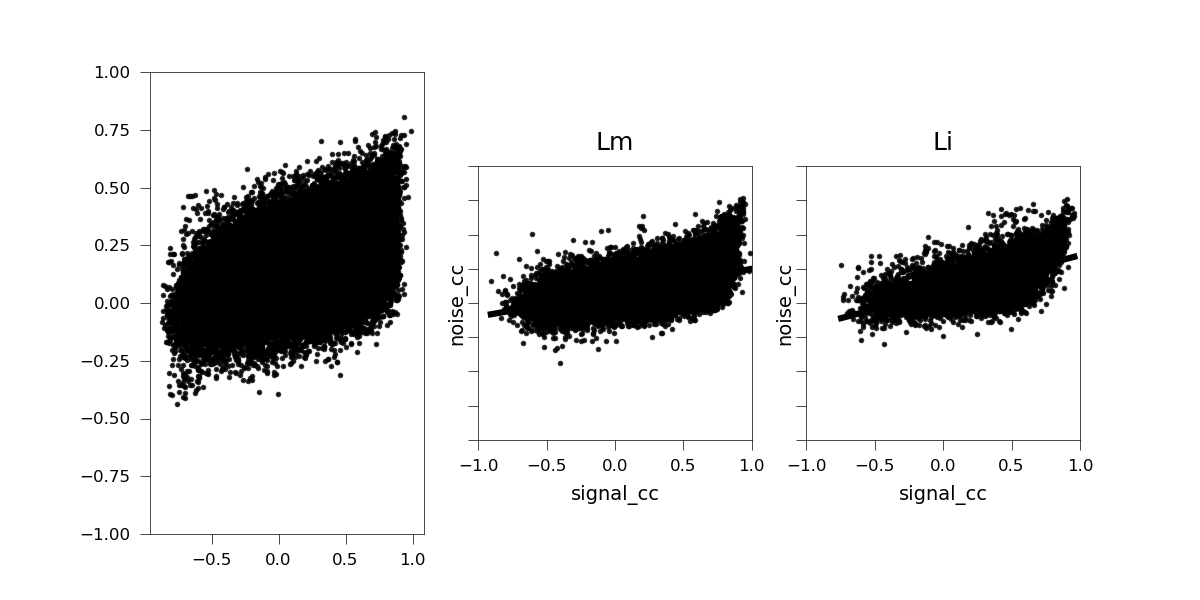


KeyboardInterrupt



In [50]:
scatter_kws={'s': 1}
fig, axn =pl.subplots(1, 2, figsize=(5,3), sharey=True)
for ci, metric in enumerate(['signal_cc', 'noise_cc']):
    ax=axn[ci]
    sns.boxplot(x='visual_area', y=metric, data=CORRS, ax=ax,
                fliersize=0,linewidth=0.5, order=visual_areas, color=[0.8]*3)
#     sns.stripplot(x='visual_area', y=metric, data=CORRS, s=1, ax=ax,
#                   alpha=0.5, color='k', order=visual_areas)
fig, axn =pl.subplots(1, 3, figsize=(6,3), sharey=True)
df = CORRS.dropna()
for va, vg in df.groupby('visual_area'):
    ax=axn[visual_areas.index(va)]
    sns.regplot(x='signal_cc', y='noise_cc', data=vg, ax=ax,
                        scatter_kws=scatter_kws, color='k')
    ax.set_box_aspect(1)
    ax.set_title(va)
    ax.set_ylim([-1, 1])
    ax.set_xlim([-1, 1])
    ax.set_aspect('equal')
    

#### Distance as a function of signal/noise cc

In [ ]:
%matplotlib notebook
ctx_maxdist = 200
df = CORRS[(CORRS.cortical_distance<=ctx_maxdist)].copy().dropna()
# Cut bins
df, dist_lut = cr.get_bins_and_cut(df, ctx_step=25, rf_step=2, 
                                   dir_step=30, ori_step=15)
# ------------------------------------------------------------
metric_vars = ['signal_cc', 'noise_cc']
y_var = 'cortical_distance'
fig, axn =pl.subplots(1, 2,figsize=(5,3), dpi=100, sharex=True)
for ri, x_var in enumerate(metric_vars):
    #x_bins = dist_lut[dist_var]['bins']
    x_bins = sorted(df['%s_label' % x_var].unique())
    xticks=np.arange(0, len(x_bins))
    ax=axn[ri]
    sns.barplot(y='%s_label' % x_var, x=y_var, data=df, ax=ax, 
                color=[0.7]*3, errwidth=0.5)
#     sns.stripplot(x='%s_label' % x_var, y=y_var, data=df, ax=ax, 
#                   s=1, alpha=0.5, color='k')
    ax.set_xticks(xticks)
    ax.set_xticklabels([round(x_bins[i], 1) if i==xticks[0]\
                        or i==xticks[-1] else ''
                       for i in xticks])
    ax.set_box_aspect(1)
pl.subplots_adjust(bottom=0.2, right=0.9, wspace=0.5, hspace=0.7, top=0.8)
fig.text(0.01, 0.92, '[%s, %s] Avg. distance metrics (%s, max_dist=%i um)' 
         % (experiment, select_stimuli, va, ctx_maxdist), fontsize=8)
pplot.label_figure(fig, data_id)

<IPython.core.display.Javascript object>

#### Binned distance, compare SIGNAL_CC (and shuffle)

<IPython.core.display.Javascript object>


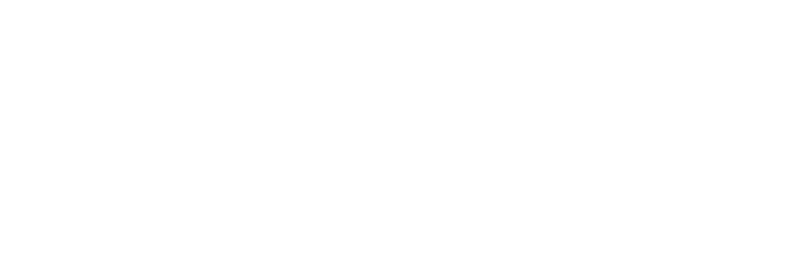

In [67]:
ctx_maxdist = 500
y_var='signal_cc'
dist_var='cortical_distance'
cmap='viridis'
tuned_or_resp = 'responsive'
# ----------------------------------
df = CORRS[(CORRS.cortical_distance<=ctx_maxdist)].copy().dropna()
# Cut bins
df, dist_lut = cr.get_bins_and_cut(df, ctx_step=25, rf_step=2, 
                                   dir_step=30, ori_step=15)
# Shuffle
combined_ = cr.shuffle_bins_by_area(df, dist_var=dist_var, n_iterations=100)

# Plot shuffled to check
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, 
                   data=combined_[combined_.condition=='shuffled'])
fg.map(sns.barplot, '%s_label' % dist_var, 'signal_cc' , ci='sd')
pl.subplots_adjust(bottom=0.2, right=0.8)

100.0


<IPython.core.display.Javascript object>


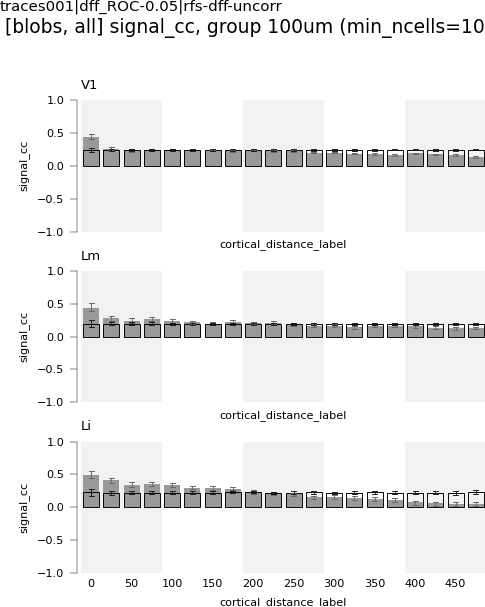

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning/ROC_minsub-none_rfs-dff-uncorr binned-dist-bar_signal_cc_v_cortical_distance_responsive_max500


In [70]:
dist_unit='um'
curr_maxdist = dist_lut[dist_var]['max_dist']
plot_pairs=False
# curr_maxdist=60 if dist_var=='rf_distance' else 500
plot_str = '_wpairs' if plot_pairs else ''
sorted_x_vars =  dist_lut[dist_var]['bins']
bin_width = 4 if dist_var=='cortical_distance' else 5
patch_step = sorted_x_vars[bin_width] #+dist_lut[dist_var]['step']
print(patch_step)
%matplotlib notebook
fig = cr.barplot_with_shuffled_distbins(combined_, dist_var, y_var,
                     curr_maxdist=curr_maxdist, round_x=0, dist_unit=dist_unit,
                     barcolor=[0.6]*3, errcolor=[0.4]*3, errcolor_shuffled=[0.1]*3,
                     plot_pairs=plot_pairs,figsize=(4,5),
                     draw_group_patch=True, bin_width=bin_width)
sns.despine(bottom=True, trim=True, offset=2)
pl.subplots_adjust(left=0.15, right=0.9, bottom=0.15, top=0.85, hspace=0.3)
fig.text(0.01, 0.95, "[%s, %s] %s, group %i%s (min_ncells=%i, *%s)" \
         % (experiment, select_stimuli, y_var, \
            patch_step, dist_unit, min_ncells, tuned_or_resp))

pplot.label_figure(fig, data_id)
figname = 'binned-dist-bar_%s_v_%s_%s_max%i%s' \
            % (y_var, dist_var, tuned_or_resp, curr_maxdist, plot_str)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

signal_cc cortical_distance
NEAR: [0.0, 25.0]
FAR: [50.0, 75.0]
2283 4610


<IPython.core.display.Javascript object>


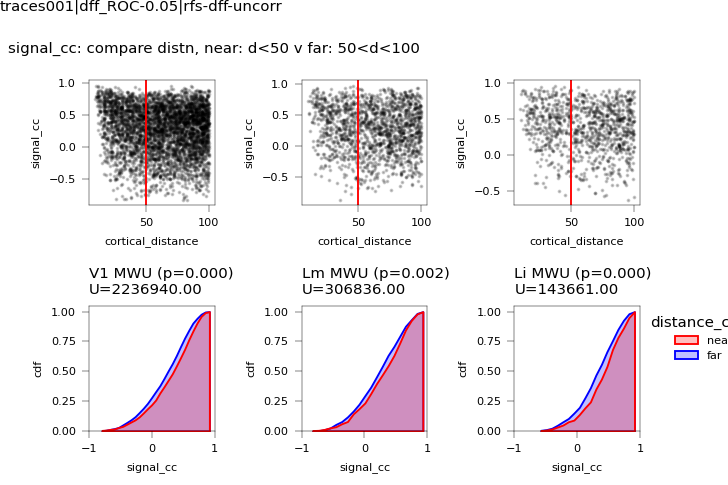

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning/ROC_minsub-none_rfs-dff-uncorr compare-bins_near50_far100_signal_cc_v_cortical_distance_responsive_max500


In [71]:
plotd = combined_[(combined_.condition=='data') 
                & (combined_.cortical_distance<=curr_maxdist)]
# y_var='signal_cc'
print(y_var, dist_var)
near_lim = 50
upper_lim = 100
near_bins = [b for b in dist_lut[dist_var]['bins'] if b<near_lim]
far_bins = [b for b in dist_lut[dist_var]['bins'] \
           if (b>=near_lim) and (b<upper_lim)]
print("NEAR:", near_bins)
print("FAR:", far_bins)

col1='r' #[0.3]*3
col2='b' #[0.8]*3
curr_dist_colors = dict((k, v) for k, v in zip(['near', 'far'], [col1, col2]))

v1df = plotd[plotd['%s_label' % dist_var].isin(near_bins)]\
            [['visual_area', dist_var, '%s_label' % dist_var, y_var, 'neuron_pair']].copy()
v2df = plotd[plotd['%s_label' % dist_var].isin(far_bins)]\
            [['visual_area', dist_var, '%s_label' % dist_var, y_var, 'neuron_pair']].copy()
print(len(v1df), len(v2df))
v1df['distance_cond'] = 'near'
v2df['distance_cond'] = 'far'
dist_df = pd.concat([v1df, v2df], axis=0, ignore_index=True)

fig, axn = pl.subplots(2, 3, sharex=False, sharey=False, figsize=(6,4), dpi=150)

for va, vg in dist_df.groupby('visual_area'):
    ax=axn[0, visual_areas.index(va)]
    ax.scatter(x=dist_var, y=y_var, data=vg, s=1, color='k', alpha=0.2)
    ax.set_xlabel(dist_var)
    ax.set_ylabel(y_var)
    ax.axvline(x=near_lim, color='r', ls='-', lw=1)
    
    ax=axn[1, visual_areas.index(va)]
    sns.histplot(x=y_var, data=vg, hue='distance_cond', ax=ax,
                 palette=curr_dist_colors, cumulative=True, common_norm=False,
                stat='probability', element='poly', lw=1)
    if va=='Li':
        pplot.sns_histplot_legend(ax, bbox_to_anchor=(1,1), loc='upper left',
                  frameon=False)
    else:
        ax.legend_.remove()
    ax.set_xlim([-1, 1])
    v1 = vg[vg.distance_cond=='near'][y_var].values
    v2 = vg[vg.distance_cond=='far'][y_var].values
    U, p = spstats.mannwhitneyu(x=v1, y=v2, alternative = 'two-sided')
    ax.set_ylabel('cdf')
    ax.set_title('%s MWU (p=%.3f)\nU=%.2f' % (va, p, U), loc='left')
for ax in axn.flat:
    ax.set_box_aspect(1)
pl.subplots_adjust(wspace=0.5, left=0.1, right=0.8, bottom=0.2, top=0.85, 
                   hspace=0.8)
fig.text(0.01, 0.9, '%s: compare distn, near: d<%i v far: %i<d<%i' \
             % (y_var, near_lim, near_lim, upper_lim), fontsize=8)
pplot.label_figure(fig, data_id)

figname = 'compare-bins_near%i_far%i_%s_v_%s_%s_max%i%s' \
            % (near_lim, upper_lim, y_var, dist_var, tuned_or_resp, curr_maxdist, plot_str)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [72]:
# y_var = 'signal_cc'
df_list = []

for va, vg in dist_df.groupby('visual_area'):
    true_distn=[]
    shuff_distn= []
    for i in np.arange(0, 1000):
        # Boot sample and get TRUE median
        bootd = vg.copy() #sample(frac=1, replace=True)
        med_v = bootd.sample(frac=1, replace=True).groupby(['distance_cond']).median()
        true_val = float(med_v.loc['near'][y_var]) \
                        - float(med_v.loc['far'][y_var])
        true_distn.append(true_val)
        # Shuffle labels
        shuff = vg.copy()
        shuff['distance_cond'] = shuff['distance_cond'].sample(frac=1, replace=False).values
        # Get medians for each group
        med_v_shuff = shuff.groupby(['distance_cond']).median()
        # Calculate diff
        shuff_val = float(med_v_shuff.loc['near'][y_var]) \
                        - float(med_v_shuff.loc['far'][y_var])
        shuff_distn.append(shuff_val)
    
    df_shuff = pd.DataFrame({'near_minus_far': shuff_distn})
    df_shuff['condition'] = 'shuffled'
    df_true = pd.DataFrame({'near_minus_far': true_distn})
    df_true['condition'] = 'true'
    df_ = pd.concat([df_true, df_shuff], axis=0)
    
    df_['visual_area'] = va
    #df_['true_difference'] = true_diff
    df_list.append(df_)

near_v_far = pd.concat(df_list, axis=0, ignore_index=True)

<IPython.core.display.Javascript object>


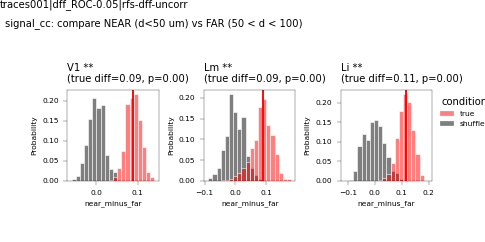

Li 0.0
Lm 0.0
V1 0.0
/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning/ROC_minsub-none_rfs-dff-uncorr compare-bins_near50_far100_shufftest_signal_cc_v_cortical_distance_responsive_max500


In [73]:

shuff_colors={'true': 'r', 'shuffled': 'k'}
fig, axn = pl.subplots(1, 3, figsize=(6,3))
for va, vg in near_v_far.groupby('visual_area'):
    ax=axn[visual_areas.index(va)]
    sns.histplot(x='near_minus_far', data=vg,  ax=ax, 
                 bins=20, edgecolor='w', common_bins=True,
                 stat='probability', common_norm=False,
                 hue='condition', palette=shuff_colors)
    # true_ = dist_df[dist_df.visual_area==va].copy()
    #true_diff = float(vg['true_difference'].unique())
    # ax.axvline(x=true_diff, color='r')
    true_diff = float(vg[vg.condition=='true']['near_minus_far'].median())
    shuff_dist = vg[vg.condition=='shuffled']['near_minus_far'].values
    n_extreme = len(np.where(shuff_dist>=true_diff)[0])
    pv = n_extreme/len(shuff_dist)
    sig_str = 'n.s.'
    if pv<0.05:
        sig_str = '**' if p<0.01 else '*'
    print(va, pv)
    ax.axvline(x=true_diff, color='r')
    ax.set_title('%s %s\n(true diff=%.2f, p=%.2f)' % (va, sig_str, true_diff, pv),
                loc='left')
    if va=='Li':
        pplot.sns_histplot_legend(ax, bbox_to_anchor=(1,1), loc='upper left', 
                                  frameon=False)
    else:
        ax.legend_.remove()
    ax.set_box_aspect(1)
    ##ax.set_xlim([-0.2, 0.3])
    
pl.subplots_adjust(wspace=0.5, right=0.8)
fig.text(0.01, 0.9, '%s: compare NEAR (d<%i um) vs FAR (%i < d < %i)' \
         % (y_var, near_lim, near_lim, upper_lim), fontsize=8)

pplot.label_figure(fig, data_id)
figname = 'compare-bins_near%i_far%i_shufftest_%s_v_%s_%s_max%i%s' \
            % (near_lim, upper_lim, y_var, dist_var, tuned_or_resp, curr_maxdist, plot_str)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

# Box

<IPython.core.display.Javascript object>


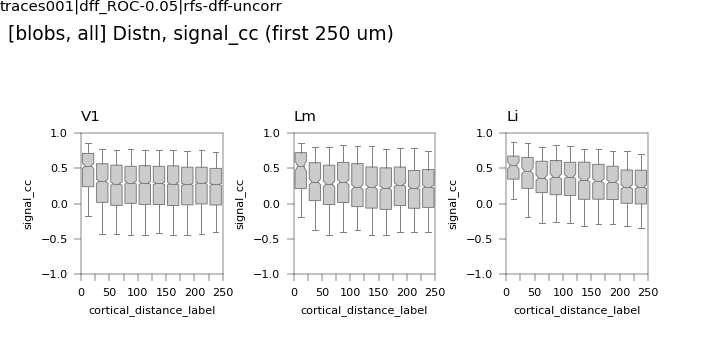

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning/ROC_minsub-none_rfs-dff-uncorr boxplot_signal_cc_v_cortical_distance_max250um_bin25


In [74]:
ctx_maxdist = 250
y_var='signal_cc'
dist_var='cortical_distance'
cmap='viridis'
tuned_or_resp = 'responsive'
ctx_step = 25
# ----------------------------------
df = CORRS[(CORRS.cortical_distance<=ctx_maxdist)].copy().dropna()
# Cut bins
df, dist_lut = cr.get_bins_and_cut(df, ctx_step=ctx_step, rf_step=2, 
                                   dir_step=30, ori_step=15)
fig, axn = pl.subplots(1, 3, figsize=(6,3), dpi=150, sharey=False)
for va, vg in df.groupby('visual_area'):
    x_var='%s_label' % dist_var
    ax=axn[visual_areas.index(va)]
    sns.boxplot(x=x_var, y=y_var, data=vg, ax=ax, whis=(5, 95),
               fliersize=0, color=[0.8]*3, linewidth=0.5, notch=True)
    ax.set_box_aspect(1)
    ax.set_ylim([-1,1])
    ax.set_yticks(np.linspace(-1, 1, 5)) #([-1,1])
    xbins = sorted([i for i in dist_lut[dist_var]['bins'] if i<=ctx_maxdist])
    xticks = np.arange(0, len(xbins))
    ax.set_xticks(xticks-0.5)
    ax.set_xticklabels([int(xbins[i]) if i in xticks[0::2] or i==xticks[-1] \
                        else '' for i in xticks])
    ax.set_title(va, loc='left')
pl.subplots_adjust(left=0.1, right=0.8, wspace=0.5)

fig.text(0.01, 0.9, '[%s, %s] Distn, %s (first %i um)' \
             % (experiment, select_stimuli, y_var, ctx_maxdist))
pplot.label_figure(fig, data_id)

figname = 'boxplot_%s_v_%s_max%ium_bin%i' \
            % (y_var, dist_var, ctx_maxdist, ctx_step)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

# DISTS:  Correlate tuning curves

In [75]:
create_new=True

In [76]:
avg_responses['morphlevel'].min()

-1

In [77]:
# Calculate distances
tuning_curve_data = avg_responses[avg_responses.morphlevel!=-1].copy()

if create_new:
    print("Creatnig new DISTS. Saving to:\n    %s" % dists_results_file)
    DISTS = cr.aggregate_tuning_curve_ccdist(tuning_curve_data, rfdf=rfdf, 
                                         rfpolys=rfpolys,sort_best_size=False,
                                         normalize=True,
                                         min_ncells=5, stimulus='blobs')
    res = {'responses': avg_responses,
           'rfdf': rfdf, 'DISTS': DISTS}
    with open(dists_results_file, 'wb') as f:
        pkl.dump(res, f, protocol=2)

Creatnig new DISTS. Saving to:
    /n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning/results_ROC_minsub-none_rfs-dff-uncorr.pkl
    (20190422_JC076_fov1 NONE, skipping overlaps)
    (20190422_JC076_fov1 NONE, skipping overlaps)
[]


In [80]:
dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning/ROC_minsub-none_rfs-dff-uncorr'

In [81]:
print(dists_results_file)

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning/results_ROC_minsub-none_rfs-dff-uncorr.pkl


# MERGE DISTS and CORRS

In [82]:
CORRS.head()

,cell_1,cell_2,signal_cc,neuron_pair,noise_cc,cortical_distance,visual_area,datakey,experiment,n_cells
0,76,80,0.616004,76_80,0.347473,50.195743,Li,20190422_JC076_fov1,blobs,29
1,76,81,0.580529,76_81,0.300683,73.768600,Li,20190422_JC076_fov1,blobs,29
2,76,119,0.603707,76_119,0.352520,82.268232,Li,20190422_JC076_fov1,blobs,29
3,76,135,0.464694,76_135,0.208156,189.151666,Li,20190422_JC076_fov1,blobs,29
4,76,136,0.167024,76_136,0.100257,163.134469,Li,20190422_JC076_fov1,blobs,29


In [83]:
DISTS.head()

,xcorr_morph,pearsons_morph,cosim_morph,cell_1,cell_2,neuron_pair,xcorr_size,pearsons_size,cosim_size,max_response,...,rf_angle_diff_abs,std_x,std_y,aspect_ratio,area_overlap,perc_overlap,overlap_index,visual_area,datakey,n_cells
0,4.063408,0.698949,0.959023,76,80,76_80,1.513496,0.777778,0.863933,0.600692,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Li,20190422_JC076_fov1,29
1,3.200770,-0.122446,0.890764,76,81,76_81,0.893625,-0.449815,0.579897,0.630790,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Li,20190422_JC076_fov1,29
2,3.685720,0.437926,0.942992,76,119,76_119,1.411922,0.674091,0.870050,0.313761,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Li,20190422_JC076_fov1,29
3,2.807402,-0.013169,0.832709,76,135,76_135,1.451351,0.347309,0.788222,0.668692,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Li,20190422_JC076_fov1,29
4,2.914360,-0.263580,0.870905,76,136,76_136,0.858750,-0.331636,0.537378,0.674573,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Li,20190422_JC076_fov1,29


In [84]:
DISTS = DISTS.rename(columns={'n_cells':'n_cells_fit'}).reset_index(drop=True)
CORRS = CORRS.rename(columns={'n_cells':'n_cells_responsive'}).reset_index(drop=True)
incl_cc_cols = ['cell_1', 'cell_2', 'signal_cc', 'neuron_pair', 'noise_cc',
               'visual_area', 'datakey', 'n_cells_responsive']

In [85]:
ccdist = pd.merge(CORRS[incl_cc_cols], DISTS,
            on=['visual_area', 'datakey', 'neuron_pair', 'cell_1', 'cell_2'], 
            how='outer', suffixes=('_fit', '_responsive'))
ccdist.shape, DISTS.shape, CORRS.shape

((138186, 28), (138186, 25), (112909, 10))

#### Check merge

In [86]:
check_pairs=[]
for (va, dk), g in DISTS.groupby(['visual_area', 'datakey']):
    curr_pairs = g['neuron_pair'].values
    cc = CORRS[(CORRS.visual_area==va) & (CORRS.datakey==dk)]
    not_in_cc = [k for k in curr_pairs if (k not in cc['neuron_pair'].values)
                and (k[::-1] not in cc['neuron_pair'].values)]
    if len(not_in_cc)>0:
        check_pairs.append(g[g['neuron_pair'].isin(not_in_cc)])
if len(check_pairs)>0:
    checkdf = pd.concat(check_pairs, axis=0, ignore_index=True)
else:
    print("Correct matches")

In [87]:
checkdf

,xcorr_morph,pearsons_morph,cosim_morph,cell_1,cell_2,neuron_pair,xcorr_size,pearsons_size,cosim_size,max_response,...,rf_angle_diff_abs,std_x,std_y,aspect_ratio,area_overlap,perc_overlap,overlap_index,visual_area,datakey,n_cells_fit
0,NaN,NaN,NaN,14,15,14_15,NaN,NaN,NaN,NaN,...,6.819677,7.709079,0.307285,0.622164,NaN,NaN,NaN,Li,20190602_JC091_fov1,87
1,NaN,NaN,NaN,14,16,14_16,NaN,NaN,NaN,NaN,...,2.416491,12.420190,2.954071,0.694701,NaN,NaN,NaN,Li,20190602_JC091_fov1,87
2,NaN,NaN,NaN,14,22,14_22,NaN,NaN,NaN,NaN,...,7.387360,4.554638,2.261077,0.702008,NaN,NaN,NaN,Li,20190602_JC091_fov1,87
3,NaN,NaN,NaN,14,24,14_24,NaN,NaN,NaN,NaN,...,19.330062,12.012340,2.205692,0.777606,NaN,NaN,NaN,Li,20190602_JC091_fov1,87
4,NaN,NaN,NaN,14,25,14_25,NaN,NaN,NaN,NaN,...,26.597918,12.298201,7.984499,0.716019,NaN,NaN,NaN,Li,20190602_JC091_fov1,87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24957,NaN,NaN,NaN,347,381,347_381,NaN,NaN,NaN,NaN,...,72.807281,4.729972,3.273197,0.062016,NaN,NaN,NaN,V1,20191006_JC110_fov1,86
24958,NaN,NaN,NaN,347,384,347_384,NaN,NaN,NaN,NaN,...,23.583483,1.010575,5.032864,0.849051,NaN,NaN,NaN,V1,20191006_JC110_fov1,86
24959,NaN,NaN,NaN,356,381,356_381,NaN,NaN,NaN,NaN,...,84.296201,3.071727,2.131770,0.935720,NaN,NaN,NaN,V1,20191006_JC110_fov1,86
24960,NaN,NaN,NaN,356,384,356_384,NaN,NaN,NaN,NaN,...,12.094563,0.647670,0.372103,0.024654,NaN,NaN,NaN,V1,20191006_JC110_fov1,86


# Boxplot distributions by distance

<IPython.core.display.Javascript object>


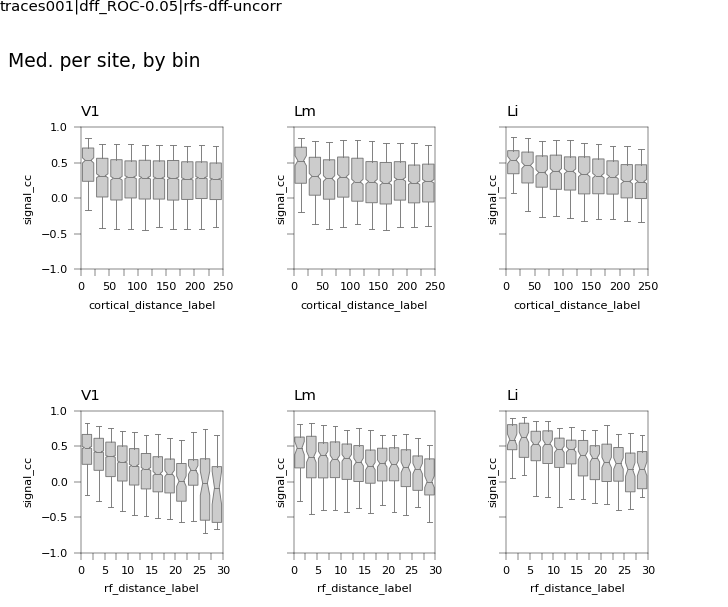

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning/ROC_minsub-none_rfs-dff-uncorr boxplot_binned-dist_signal_cc


In [94]:
%matplotlib notebook
y_var = 'signal_cc'
dist_vars=['cortical_distance', 'rf_distance']
fit_sites=True
ctx_maxdist=250
rf_maxdist = 30
min_npairs=10
min_npoints=5

fig, axn = pl.subplots(2,3, figsize=(6,5), dpi=150, sharex=False, sharey=True)
for ri, dist_var in enumerate(dist_vars):
    curr_maxdist = ctx_maxdist if dist_var=='cortical_distance' else rf_maxdist
    df, dist_lut = cr.get_bins_and_cut(ccdist[ccdist[dist_var]<=curr_maxdist], 
                                   ctx_step=25, overlap_step=0.2, rf_step=2.5, 
                                   equal_bins=False)

    for va, vg in df.groupby('visual_area'):
        x_var='%s_label' % dist_var
        ax=axn[ri, visual_areas.index(va)]
        sns.boxplot(x=x_var, y=y_var, data=vg, ax=ax, whis=(5, 95),
                   fliersize=0, color=[0.8]*3, linewidth=0.5, notch=True)
        ax.set_box_aspect(1)
        ax.set_ylim([-1,1])
        ax.set_yticks(np.linspace(-1, 1, 5)) #([-1,1])
        xbins = sorted([i for i in dist_lut[dist_var]['bins'] if i<=curr_maxdist])
        xticks = np.arange(0, len(xbins))
        ax.set_xticks(xticks-0.5)
        ax.set_xticklabels([int(xbins[i]) if i in xticks[0::2] or i==xticks[-1] \
                            else '' for i in xticks])
        ax.set_title(va, loc='left')
pl.subplots_adjust(left=0.1, right=0.8, wspace=0.5)

fig.text(0.01, 0.9, 'Med. per site, by bin')

pplot.label_figure(fig, data_id)
figname = 'boxplot_binned-dist_%s' % (y_var)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

# RF distance metrics, per CTX bin

In [47]:
ctx_maxdist=800
df, dist_lut = cr.get_bins_and_cut(DISTS[DISTS.cortical_distance<=ctx_maxdist], 
                                   ctx_step=25, overlap_step=0.2, rf_step=2.0, 
                                   equal_bins=False)

cortical_distance 25


<IPython.core.display.Javascript object>


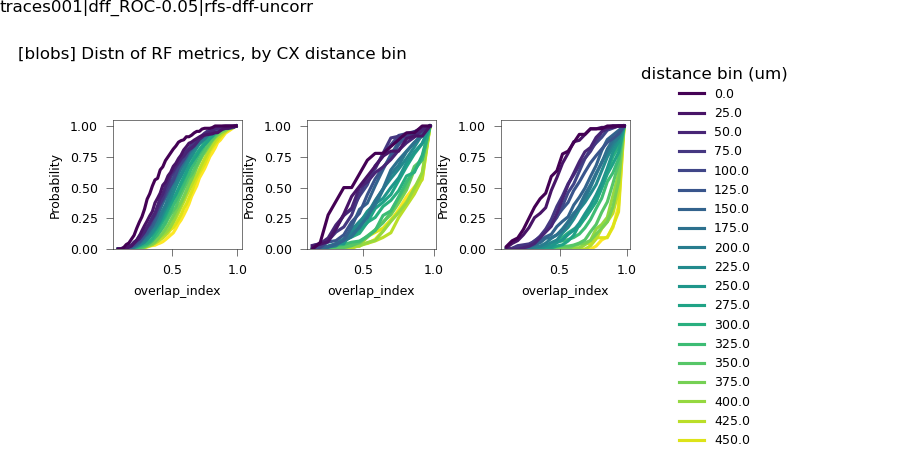

Li
/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning/ROC_minsub-exclude_rfs-dff-uncorr cdf_RFdist_per_CXbin_25um-step_overlap_index


In [48]:
dist_var = 'cortical_distance'
count_var = 'overlap_index'
dist_bins = list(dist_lut[dist_var]['bins'])
hue_step = dist_lut[dist_var]['step']
print(dist_var, hue_step)

n_bins = 20
curr_bins = dist_bins[0:n_bins]
plotd = df[df['%s_label' % dist_var].isin(curr_bins)].copy()

fig, axn = pl.subplots(1, 3, figsize=(6,3), dpi=150)
for va, vg in plotd.groupby(['visual_area']):
    ax=axn[visual_areas.index(va)]
    sns.histplot(x=count_var, data=vg, ax=ax,
                hue='%s_label' % dist_var, cumulative=True, common_norm=False,
                element='poly', fill=False, stat='probability', palette='viridis')
    ax.set_box_aspect(1)
    if va=='Li':
        print(va)
        pplot.sns_histplot_legend(ax, bbox_to_anchor=(1, 1.5), loc='upper left', 
                                  frameon=False, title='distance bin (um)')
    else:
        ax.legend_.remove()
pl.subplots_adjust(bottom=0.3, right=0.7, wspace=0.5)

pplot.label_figure(fig, data_id)
fig.text(0.02, 0.87, '[%s] Distn of RF metrics, by CX distance bin' \
         % (experiment), fontsize=8)

figname = 'cdf_RFdist_per_CXbin_%sum-step_%s' % (hue_step, count_var)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)


# Medians by FOV (bar)

In [797]:
importlib.reload(cr)

<module 'analyze2p.correlations' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/correlations.py'>

<IPython.core.display.Javascript object>


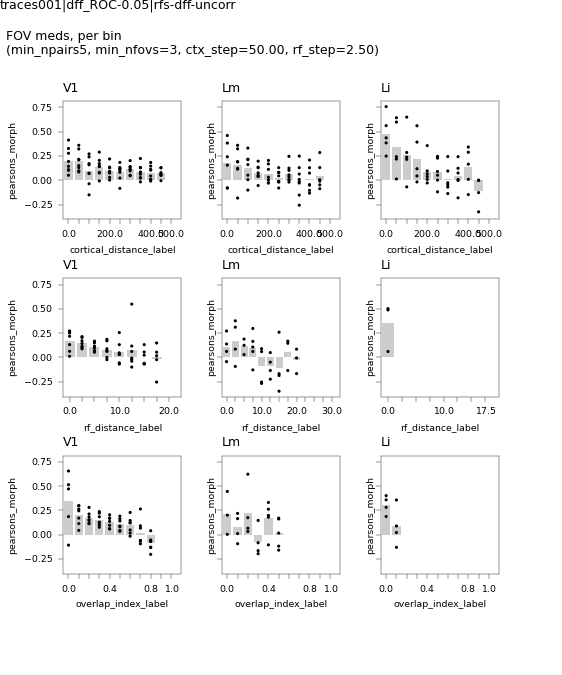

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning/ROC_minsub-exclude_rfs-dff-uncorr barplot_pearsons_morph_v_dist-metrics


In [801]:
%matplotlib notebook
metric = 'pearsons_morph'

ctx_maxdist=500
min_nfovs=3
min_npairs=5

ctx_step = 50
rf_step=2.5
df, dist_lut = cr.get_bins_and_cut(DISTS[DISTS.cortical_distance<=ctx_maxdist], 
                                   ctx_step=ctx_step, rf_step=rf_step, 
                                   overlap_step=0.1, equal_bins=False)
dist_vars=['cortical_distance', 'rf_distance', 'overlap_index']

%matplotlib notebook
fig = cr.barplot_fov_medians_per_bin(metric, dist_vars, df, dist_lut, 
                min_npairs=min_npairs, min_nfovs=min_nfovs, round_x=1,
                xtick_step=4, sharex_dist=False, barcolor=[0.8]*3, strip_size=2,
                figsize=(5,6))
                             
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.15, hspace=0.5, top=0.85)
fig.text(0.01, 0.92, \
        'FOV meds, per bin\n(min_npairs%i, min_nfovs=%i, ctx_step=%.2f, rf_step=%.2f)'\
         % (min_npairs, min_nfovs, ctx_step, rf_step), fontsize=8)

pplot.label_figure(fig, data_id)
figname = 'barplot_%s_v_dist-metrics' % (metric)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

# Heatmaps: cortical vs. RF distance

In [793]:
# Split distances into X um bins
x_var = 'cortical_distance'
y_var = 'overlap_index'
hue_var = 'pearsons_size'
# -----------------------------
ctx_maxdist = 500 #500
rf_maxdist=50
if hue_var == 'signal_cc':
    df, dist_lut = cr.get_bins_and_cut(ccdist[(ccdist.cortical_distance<=ctx_maxdist)
                                        & (ccdist.rf_distance<=rf_maxdist)], 
                                   ctx_step=25, rf_step=2, overlap_step=0.1)
else:
    df, dist_lut = cr.get_bins_and_cut(DISTS[(DISTS.cortical_distance<=ctx_maxdist)
                                        & (DISTS.rf_distance<=rf_maxdist)], 
                                   ctx_step=25, rf_step=2, overlap_step=0.1)
    
print(df.groupby([x_var, y_var])[hue_var].mean().min())
print(df.groupby([x_var, y_var])[hue_var].mean().max())

-0.9965961555009633
0.999857949592178


<IPython.core.display.Javascript object>


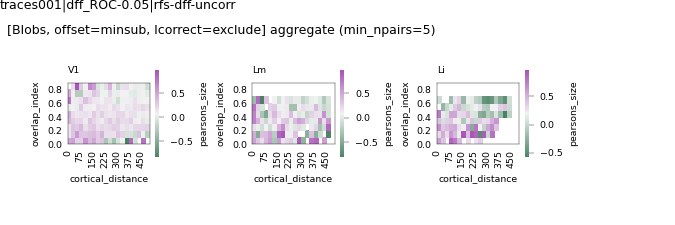

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning/ROC_minsub-exclude_rfs-dff-uncorr heatmaps_aggrFOV_overlap_index_v_cortical_distance_hue-pearsons_size


In [794]:
# x_var = 'cortical_distance'
# y_var = 'overlap_index'
# hue_var = 'pearsons_morph'
# -----------------------------
min_npairs=5
x_bins = dist_lut[x_var]['bins']
y_bins = dist_lut[y_var]['bins']
hue_min, hue_max = None, None #@(-1, 1)
#hue_min, hue_max =  (-0.2, 0.5) #if hue_var=='pearsons_morph' else (-0.6, 0.6)
#hue_min, hue_max =  (-0.3, 0.8)

cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True)
x_var_name = '%s_label' % x_var
y_var_name = '%s_label' % y_var

fig, axn = pl.subplots(1, 3, figsize=(6, 2), dpi=150, sharex=True, sharey=False)
# cbar_ax = fig.add_axes([0.8, 0.3, 0.01, 0.3])
for ai, (va, vg) in enumerate(df.groupby('visual_area')):
    ax=axn[visual_areas.index(va)]
    cnts = vg.groupby([x_var_name, y_var_name])['neuron_pair'].count().reset_index()
    valid_x = cnts[cnts['neuron_pair']>=min_npairs][x_var_name].unique()
    valid_y = cnts[cnts['neuron_pair']>=min_npairs][y_var_name].unique()
    df0 = vg[(vg[x_var_name].isin(valid_x)) & (vg[y_var_name].isin(valid_y))]

    ax=cr.heatmap_tuning_v_distance(df0, x_bins, y_bins, ax=ax,
                                      x_var=x_var, y_var=y_var, 
                                      hue_var=hue_var, hue_norm=(hue_min, hue_max),
                                      cmap=cmap, cbar=True, cbar_kws={'shrink':0.5})
#                                       cbar_ax=cbar_ax if ai==0 else None)
    ax.set_title(va, loc='left', fontsize=6)
    yticks = np.arange(0, len(y_bins))
    curr_ylim = df0.dropna()[y_var_name].max()
    ax.set_ylim([0, list(y_bins).index(curr_ylim)])
    ax.set_ylabel(y_var)
    ax.set_xlabel(x_var)
    # ax.invert_yaxis()
fig.text(0.01, 0.85, '[Blobs, offset=%s, lcorrect=%s] aggregate (min_npairs=%i)' 
         % (offset_type, lcorrection, min_npairs), fontsize=8)
pl.subplots_adjust(wspace=0.8, right=0.8, left=0.1)

pplot.label_figure(fig, data_id)
figname = 'heatmaps_aggrFOV_%s_v_%s_hue-%s' % (y_var, x_var, hue_var)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

<IPython.core.display.Javascript object>


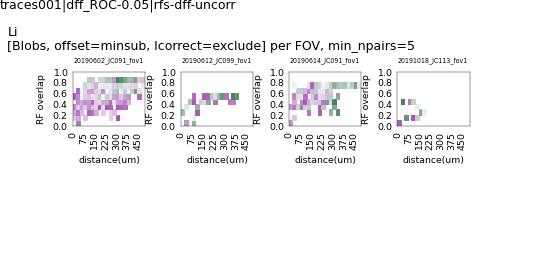

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning/ROC_minsub-exclude_rfs-dff-uncorr heatmaps_byFOV_Li_overlap_index_v_cortical_distance_hue-pearsons_size


<IPython.core.display.Javascript object>


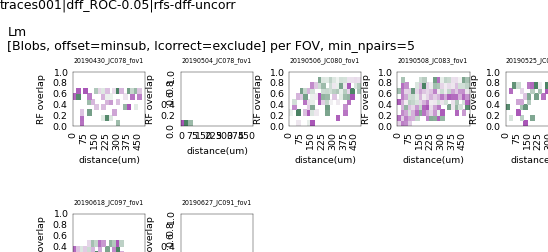

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning/ROC_minsub-exclude_rfs-dff-uncorr heatmaps_byFOV_Lm_overlap_index_v_cortical_distance_hue-pearsons_size


<IPython.core.display.Javascript object>


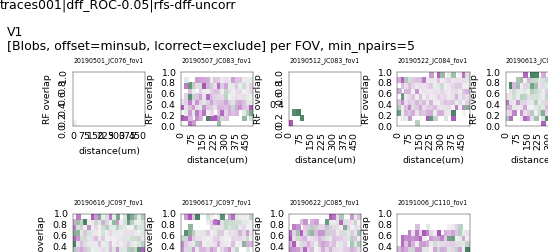

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning/ROC_minsub-exclude_rfs-dff-uncorr heatmaps_byFOV_V1_overlap_index_v_cortical_distance_hue-pearsons_size


In [795]:
nr=2
nc=5

#hue_min, hue_max = (-.6, 0.6) #if hue_var=='pearsons_morph' else (-0.6, 0.6)
cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True)

for va, vg in df.groupby('visual_area'):
    fig, axn = pl.subplots(nr, nc, figsize=(6.5,3), dpi=150, 
                           sharex=False, sharey=False)
    cbar_ax = fig.add_axes([0.81, 0.3, 0.01, 0.3])
    grped_means = vg.groupby(['%s_label' % x_var, '%s_label' % y_var]).mean()
    i=0
    for ai, (ax, (dk, df_)) in enumerate(zip(axn.flat, vg.groupby('datakey'))):
        ax=cr.heatmap_tuning_v_distance(df_, x_bins, y_bins, ax=ax,
                                      x_var=x_var, y_var=y_var, 
                                      hue_var=hue_var, hue_norm=(hue_min, hue_max),
                                      cmap=cmap, cbar=ai==0, #lw=0.5,
                                      cbar_ax=cbar_ax if ai==0 else None)
        ax.set_title(dk, loc='left', fontsize=4)
        ax.set_xlabel('distance(um)')
        ax.set_ylabel('RF overlap')
        i+=1
    for ai in np.arange(i, nr*nc):
        axn.flat[ai].axis('off')
    pl.subplots_adjust(wspace=0.5, right=0.79, left=0.1)
    fig.text(0.01, 0.85, '%s\n[Blobs, offset=%s, lcorrect=%s] per FOV, min_npairs=%i' 
         % (va, offset_type, lcorrection, min_npairs), fontsize=8)

    pplot.label_figure(fig, data_id)
    figname = 'heatmaps_byFOV_%s_%s_v_%s_hue-%s' % (va, y_var, x_var, hue_var)
    pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
    print(dst_dir, figname)

In [69]:
df0.groupby([x_var, y_var])['neuron_pair'].count()

cortical_distance  overlap_index
8.901078           0.452692         1
9.793585           0.389434         1
9.973373           0.119427         1
                   0.245038         1
10.285077          0.409872         1
                                   ..
499.843022         0.713651         1
499.894386         0.433298         1
                   0.764703         1
499.896163         0.700457         1
499.985442         0.901521         1
Name: neuron_pair, Length: 13879, dtype: int64

In [80]:
cnts.fillna(value=0)

,cortical_distance_label,overlap_index_label,neuron_pair
0,0.0,0.10,5
1,0.0,0.15,10
2,0.0,0.20,18
3,0.0,0.25,20
4,0.0,0.30,22
...,...,...,...
353,475.0,0.75,84
354,475.0,0.80,59
355,475.0,0.85,41
356,475.0,0.90,35


<IPython.core.display.Javascript object>


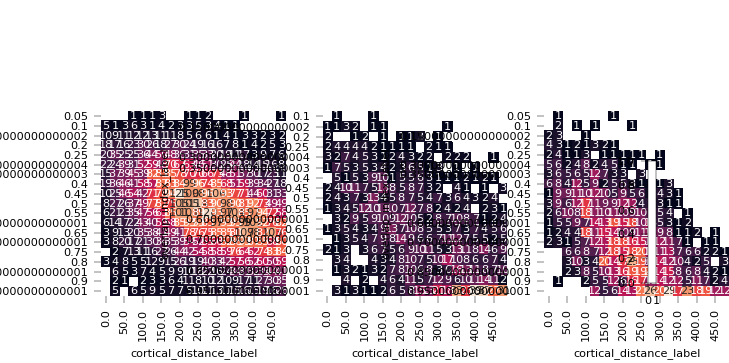

In [86]:
fig, axn = pl.subplots(1, 3, figsize=(6, 3), dpi=150, sharex=True, sharey=False)
cbar_ax = fig.add_axes([0.8, 0.3, 0.01, 0.3])
for ai, (va, vg) in enumerate(df.groupby('visual_area')):
    ax=axn[visual_areas.index(va)]
    cnts = vg.groupby([x_var_name, y_var_name])['neuron_pair'].count().reset_index()
    cnt_table = cnts.fillna(value=0).pivot(y_var_name, x_var_name, 'neuron_pair')
    sns.heatmap(cnt_table, annot=True, fmt=".0f", ax=ax,
               annot_kws={'fontsize': 6}, cbar=False)
    ax.set_box_aspect(1)
    

In [56]:
curr_ylim

44.0

In [167]:
'20190315_JC070_fov1' in rfdf['datakey'].unique()

False

In [ ]:
cnts = plotd.groupby([x_var_name, y_var_name])['neuron_pair'].count()


<IPython.core.display.Javascript object>


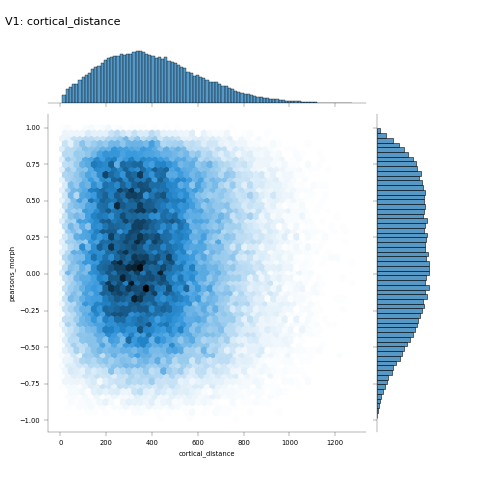

<IPython.core.display.Javascript object>


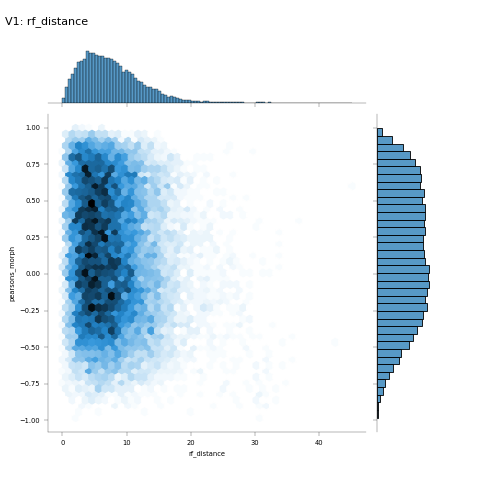

<IPython.core.display.Javascript object>


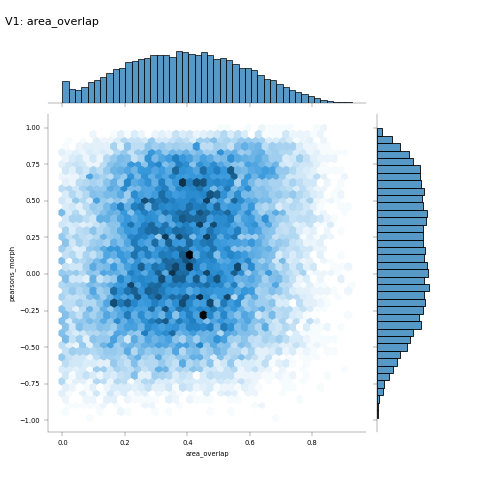

In [34]:
%matplotlib notebook
y_var='pearsons_morph'
for dist_var in ['cortical_distance', 'rf_distance', 'area_overlap']:
    fg = sns.jointplot(x=dist_var, y=y_var, data=plotd, 
                    kind='hex', height=6, )
    pl.subplots_adjust(left=0.1, bottom=0.1, top=0.9, right=0.9)
    fg.fig.text(0.01, 0.95, '%s: %s' % (va, dist_var),
               fontsize=10)
    
    figname = 'joint_%s_and_%s_V1' % (y_var, dist_var)
    pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

In [53]:
min_ncells=50
plotd = df[df['n_cells']>=min_ncells]

In [54]:
df['visual_area'].unique()

array(['Li', 'Lm', 'V1'], dtype=object)

<IPython.core.display.Javascript object>


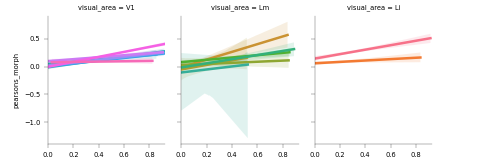

In [55]:
scatter_kws={'s':1}

fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, 
                   hue='datakey', height=2, data=plotd)
fg.map(sns.regplot, dist_var, y_var,
            scatter_kws=scatter_kws, scatter=False)
# ax.legend_.remove()
pl.subplots_adjust(left=0.1, bottom=0.1, top=0.9, right=0.9)
fig.text(0.01, 0.95, '%s: %s' % (va, dist_var),
           fontsize=10)
figname = 'joint_%s_and_%s_V1' % (y_var, dist_var)

In [189]:
import analyze2p.scatter as sct

In [342]:
dk='20190616_JC097_fov1'
va='V1'

ctx_maxdist=1000
equal_bins=False
n_bins=10

df = DISTS.copy()
# Split distances into X um bins
ctx_step=25
if equal_bins:
    ctx_bins = np.linspace(0, ctx_maxdist, n_bins)
else:
    ctx_bins = np.arange(0, 1200+ctx_step, ctx_step)
df = cr.cut_bins(df, ctx_bins, 'cortical_distance')

rf_step=2.5
curr_maxdist = DISTS[(DISTS.visual_area==va) 
                    & (DISTS.datakey==dk)]['rf_distance'].max()
if equal_bins:
    rf_bins = np.linspace(0, curr_maxdist, n_bins)
else:
    rf_bins = np.arange(0, 40+rf_step, rf_step)
df = cr.cut_bins(df, rf_bins, 'rf_distance')
df.head()

perc_step = 0.05
if equal_bins:
    perc_bins = np.linspace(0, 1, n_bins)
else:
    perc_bins = np.arange(0, 1+perc_step, perc_step)
df = cr.cut_bins(df, perc_bins, 'area_overlap')
# Split
dist_lut = {'cortical_distance': {'bins': ctx_bins, 'step': ctx_step},
            'rf_distance': {'bins': rf_bins, 'step': rf_step},
            'area_overlap': {'bins': perc_bins, 'step': perc_step}           }

plotd = df[(df.cortical_distance<=ctx_maxdist)].copy().dropna()
vg = plotd[(plotd.datakey==dk) & (plotd.visual_area==va)].dropna()

<IPython.core.display.Javascript object>


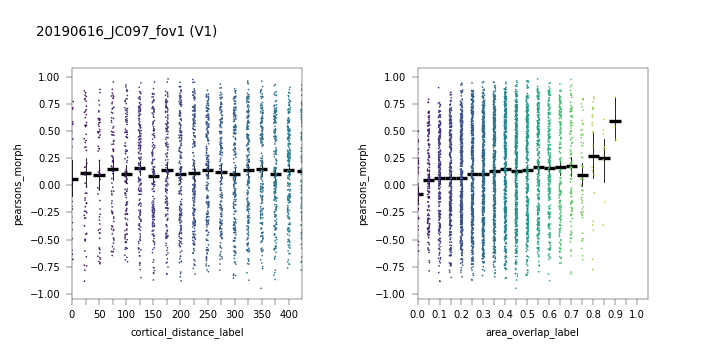

Text(0.05, 0.9, '20190616_JC097_fov1 (V1)')

In [354]:
%matplotlib notebook
scatter_kws={'s':0.5}
dist_vars = ['cortical_distance', 'area_overlap']
curr_ctx_maxdist = 400

r_list=[]

fig, axn = pl.subplots(1, 2, figsize=(6,3), dpi=150)

for ax, dist_var in zip(axn.flat, dist_vars):
    x_bins = [k for k in dist_lut[dist_var]['bins'] if k<=curr_ctx_maxdist]
    curr_maxdist = max(x_bins)
    if x_var=='cortical_distance':
        df_ = vg[vg.cortical_distance<=curr_ctx_maxdist].copy()
    else:
        df_ = vg.copy()
        
    x_var = '%s_label' % dist_var
#     sns.boxplot( x=x_var, y='pearsons_morph', ax=ax,
#                 data=df_, fliersize=0, linewidth=0.5, width=0.8,
#                color=[0.8]*3)
    sns.stripplot( x=x_var, y='pearsons_morph', ax=ax,
                data=df_, s=1, palette='viridis')
    sns.pointplot( x=x_var, y='pearsons_morph', ax=ax,
                data=df_, scale=1, markers='_', join=False, color='k',
                 errwidth=0.5)

    ax.set_xticks(np.arange(0, len(x_bins)))
    if dist_var=='area_overlap':
        ax.set_xticklabels([round(i, 1) if i in x_bins[0::2] else '' for i in x_bins])
    else:
        ax.set_xticklabels([int(i) if i in x_bins[0::2] else '' for i in x_bins])        
    ax.set_xlim([0, len(x_bins)])
for ax in axn.flat:
    ax.set_box_aspect(1)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.1, wspace=0.5)

fig.text(0.05, 0.9, '%s (%s)' % (dk, va), fontsize=8)

<IPython.core.display.Javascript object>


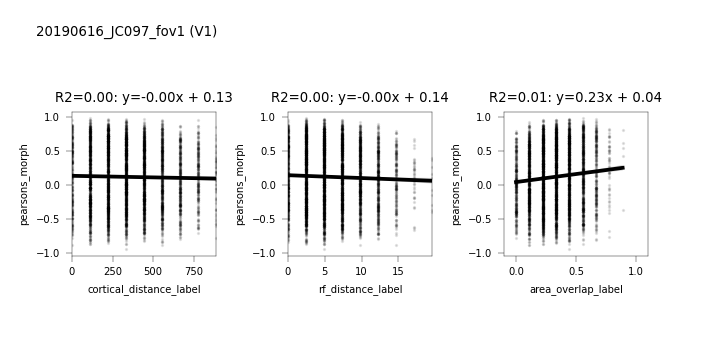

Text(0.05, 0.9, '20190616_JC097_fov1 (V1)')

In [336]:
%matplotlib notebook
scatter_kws={'s':0.5}
dist_vars = ['cortical_distance', 'rf_distance', 'area_overlap']
curr_ctx_maxdist = 800

r_list=[]

fig, axn = pl.subplots(1, 3, figsize=(6,3), dpi=150)

for ax, dist_var in zip(axn.flat, dist_vars):
    x_bins = dist_lut[dist_var]['bins']
    curr_maxdist = max(x_bins)
    if x_var=='cortical_distance':
        df_ = vg[vg.cortical_distance<=curr_ctx_maxdist].copy()
    else:
        df_ = vg.copy()
        
    x_var = '%s_label' % dist_var

    sns.regplot( x=x_var, y='pearsons_morph', ax=ax,
                data=df_, scatter_kws={'alpha':0.1, 's': 1}, color='k')
    # fit linear
    xvs = df_[x_var].values
    yvs = df_[y_var].values
    regr_, linmodel = sct.do_linear_fit(xvs, yvs, model='ridge')    
    regr_['dist_var'] = x_var 
    r_list.append(regr_)
    (r2, coef, intercept) = regr_[['R2', 'coefficient', 'intercept']].values[0]
    ax.set_title('R2=%.2f: y=%.2fx + %.2f' % (r2, coef, intercept))
    if 'area_overlap' in x_var:
        ax.set_xlim([-0.1, 1.1])

for ax in axn.flat:
    ax.set_box_aspect(1)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.1, wspace=0.5)

fig.text(0.05, 0.9, '%s (%s)' % (dk, va), fontsize=8)

In [279]:
np.linspace(0, 1, 11)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

<IPython.core.display.Javascript object>


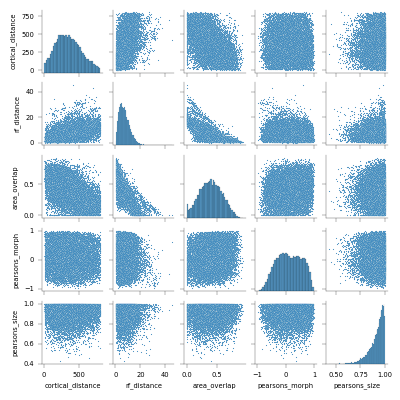

In [235]:
plotd = DISTS[(DISTS.cortical_distance<=ctx_maxdist)].copy().dropna()

vg = plotd[plotd.visual_area==va]

sns.pairplot(data=vg, vars=['cortical_distance', 'rf_distance', 
                               'area_overlap','pearsons_morph', 'pearsons_size'],
            size=1, plot_kws={'s':1})


fg.fig.text(0.01, 0.95, '%s: %s' % (va, dist_var),
           fontsize=10)

figname = 'pairplots_V1'
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

<IPython.core.display.Javascript object>


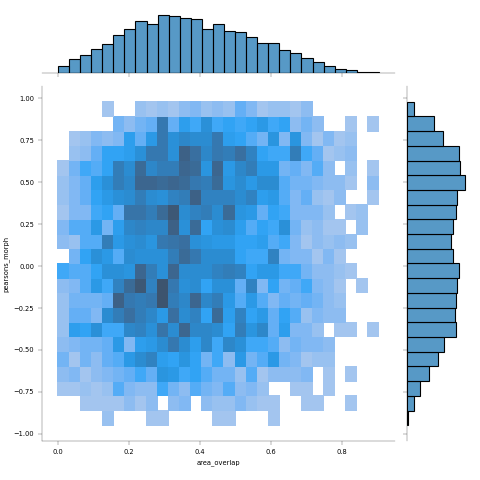

In [222]:
ctx_maxdist=1200
plotd = DISTS[(DISTS.cortical_distance<=ctx_maxdist)].copy().dropna()

dk='20190616_JC097_fov1'
va='V1'
df_ = plotd[(plotd.datakey==dk) & (plotd.visual_area==va)].dropna()

sns.jointplot(x=x_var, y=y_var, data=df_, ax=ax, kind='hist')

In [129]:
x_var

'cortical_distance'

In [77]:
df_.groupby(['datakey'])['neuron_pair'].count()  

datakey
20191006_JC110_fov1    3655
Name: neuron_pair, dtype: int64

RF distance (deg)


<IPython.core.display.Javascript object>


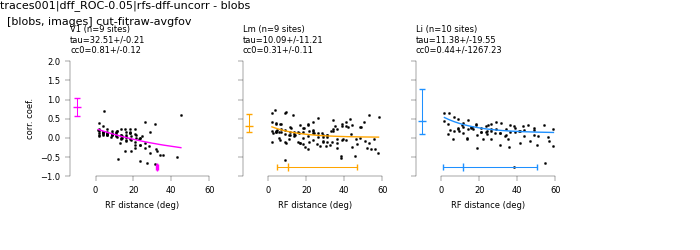

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning rf_distance_curves_cut-fitraw-avgfov


In [72]:
x_pos = -100 if to_quartile=='cortical_distance' else -10
xlabel='cortical distance (um)' if to_quartile=='cortical_distance' \
            else 'RF distance (deg)'
print(xlabel)
use_best_r2=False
fig = cr.plot_fit_distance_curves(df, resdf.dropna(),  metric=metric, 
                            to_quartile=to_quartile, 
                            use_best_r2=use_best_r2, fit_sites=fit_sites,
                            area_colors=area_colors, xlabel=xlabel,
                            x_pos=x_pos, y_pos=-0.75,elinewidth=0.75,
                            ylim=(-1, 2), )
fig.text(0.01, 0.9, '[%s, %s] %s' \
             % (experiment, select_stimuli, bin_type), fontsize=8)

pplot.label_figure(fig, '%s - %s' % (data_id, experiment))
figname = '%s_curves_%s%s' % (to_quartile, bin_type, stim_str)
#pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [559]:
dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning'

In [516]:
va='V1'
dk='20190616_JC097_fov1'
df_ = avg_responses[(avg_responses.visual_area==va) & (avg_responses.datakey==dk)]

In [519]:

posdf_ = aggr.add_roi_positions(df_)
if rfdf is not None:
    posdf0 = posdf_.copy()
    curr_rfs = rfdf[(rfdf.visual_area==va) & (rfdf.datakey==dk)].copy()
    posdf_ = cr.get_roi_pos_and_rfs(posdf0, curr_rfs, rfs_only=False, 
                                merge_cols=['visual_area', 'datakey', 'cell'])
    if posdf_.shape[0]==0:
        print(va, dk)

In [520]:
posdf_

,visual_area,datakey,cell,ml_pos,ap_pos,x0,y0
0,V1,20190616_JC097_fov1,0,909.977299,1078.506458,34.263130,-10.628686
1,V1,20190616_JC097_fov1,1,864.288063,1099.246967,NaN,NaN
2,V1,20190616_JC097_fov1,2,852.865753,1073.897456,30.848143,-6.732552
3,V1,20190616_JC097_fov1,9,873.806654,1023.198434,39.429009,-3.330024
4,V1,20190616_JC097_fov1,11,883.325245,993.239922,35.470047,-12.506376
...,...,...,...,...,...,...,...
180,V1,20190616_JC097_fov1,424,207.505284,1048.547945,29.780096,-2.802732
181,V1,20190616_JC097_fov1,425,32.363209,772.007828,20.431419,-7.071060
182,V1,20190616_JC097_fov1,426,45.689237,811.184344,NaN,NaN
183,V1,20190616_JC097_fov1,429,138.971429,520.817221,20.485330,-13.131780


In [524]:

cc = cr.get_pw_curve_correlations(df_, stimulus='blobs')
diffs_ = cc.copy()

if 'x0' in posdf_.columns:
    adist = cr.get_pw_distance(diffs_, posdf_, xcoord='x0', ycoord='y0', 
                             label='rf_distance', add_eccentricity=True)
else:
    adist = cr.get_pw_distance(diffs_, posdf_, xcoord='ml_pos', ycoord='ap_pos', 
                             label='cortical_distance', add_eccentricity=False)


In [526]:
adist.head()

,xcorr_morph,pearsons_morph,cosim_morph,cell_1,cell_2,neuron_pair,xcorr_size,pearsons_size,cosim_size,rf_distance,max_ecc,min_ecc,cortical_distance
0,3.502203,-0.030559,0.876929,0,1,0_1,1.900788,0.848862,0.958029,NaN,NaN,NaN,50.176439
1,2.839756,0.780673,0.942752,0,2,0_2,1.832618,0.920442,0.977413,5.180927,35.873821,31.574280,57.297221
2,3.129756,0.676105,0.936768,0,9,0_9,1.694492,0.994842,0.991813,8.941855,39.569379,35.873821,66.085498
3,2.824641,-0.381755,0.813232,0,11,0_11,1.768774,0.915901,0.965303,2.232122,37.610287,35.873821,89.334843
4,2.598988,0.200115,0.860275,0,12,0_12,2.073319,0.958303,0.991609,9.247455,40.524749,35.873821,129.947597


In [486]:
no_rfs=[]

curr_rfs=None
if rfdf is not None:
    curr_rfs = rfdf[(rfdf.visual_area==va) & (rfdf.datakey==dk)].copy()
    posdf = cr.get_roi_pos_and_rfs(df_, curr_rfs, rfs_only=False, 
                                merge_cols=['visual_area', 'datakey', 'cell'])
    if curr_rfs.shape[0]==0:
        no_rfs.append((va, dk, exp))
else:
    posdf = aggr.add_roi_positions(df_)
no_rfs

[]

In [490]:
posdf_ = aggr.add_roi_positions(df_)
posdf_

,visual_area,datakey,cell,config,response,size,morphlevel,experiment,animalid,fov,session,fov_xpos,fov_xpos_pix,fov_ypos,fov_ypos_pix,ml_pos,ap_pos
0,V1,20190616_JC097_fov1,0,config006,0.073549,10.0,0,blobs,JC097,FOV1_zoom2p0x,20190616,99.093542,43.0,62.822701,33.0,909.977299,1078.506458
1,V1,20190616_JC097_fov1,0,config007,0.062874,20.0,0,blobs,JC097,FOV1_zoom2p0x,20190616,99.093542,43.0,62.822701,33.0,909.977299,1078.506458
2,V1,20190616_JC097_fov1,0,config008,0.089596,30.0,0,blobs,JC097,FOV1_zoom2p0x,20190616,99.093542,43.0,62.822701,33.0,909.977299,1078.506458
3,V1,20190616_JC097_fov1,0,config009,0.102889,40.0,0,blobs,JC097,FOV1_zoom2p0x,20190616,99.093542,43.0,62.822701,33.0,909.977299,1078.506458
4,V1,20190616_JC097_fov1,0,config010,0.181599,50.0,0,blobs,JC097,FOV1_zoom2p0x,20190616,99.093542,43.0,62.822701,33.0,909.977299,1078.506458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8320,V1,20190616_JC097_fov1,431,config046,0.047672,10.0,106,blobs,JC097,FOV1_zoom2p0x,20190616,258.104110,112.0,287.461448,151.0,685.338552,919.495890
8321,V1,20190616_JC097_fov1,431,config047,0.014780,20.0,106,blobs,JC097,FOV1_zoom2p0x,20190616,258.104110,112.0,287.461448,151.0,685.338552,919.495890
8322,V1,20190616_JC097_fov1,431,config048,0.016424,30.0,106,blobs,JC097,FOV1_zoom2p0x,20190616,258.104110,112.0,287.461448,151.0,685.338552,919.495890
8323,V1,20190616_JC097_fov1,431,config049,0.016479,40.0,106,blobs,JC097,FOV1_zoom2p0x,20190616,258.104110,112.0,287.461448,151.0,685.338552,919.495890


In [ ]:

cc = get_pw_curve_correlations(df_, n_intervals=n_intervals, stimulus=stimulus)
diffs_ = cc.copy()

# # Cortical and RF difff
# if 'ml_pos' not in df_.columns:
#     if stimulus=='blobs':
#         posdf0 = df_[['visual_area', 'datakey', 'experiment', 'cell']].drop_duplicates()
#     else:
#         posdf0 = df_.copy()
#     posdf_ = aggr.add_roi_positionsS(posdf0)
# else:
#     posdf_ = df_.copy()        

if 'x0' in posdf_.columns:
    adist = get_pw_distance(diffs_, posdf_, xcoord='x0', ycoord='y0', 
                             label='rf_distance', add_eccentricity=True)
else:
    adist = get_pw_distance(diffs_, posdf_, xcoord='ml_pos', ycoord='ap_pos', 
                             label='cortical_distance', add_eccentricity=False)

assert adist.shape[0]==cc.shape[0], 'Bad merging: %s, %s' (va, dk)